In [6]:
!unzip "/content/drive/My Drive/ground_truth.zip" -d "/content/drive/My Drive/ground_truth"

Archive:  /content/drive/My Drive/ground_truth.zip
   creating: /content/drive/My Drive/ground_truth/ground_truth/
  inflating: /content/drive/My Drive/ground_truth/ground_truth/GT_IMG_1.mat  
  inflating: /content/drive/My Drive/ground_truth/ground_truth/GT_IMG_10.mat  
  inflating: /content/drive/My Drive/ground_truth/ground_truth/GT_IMG_100.mat  
  inflating: /content/drive/My Drive/ground_truth/ground_truth/GT_IMG_101.mat  
  inflating: /content/drive/My Drive/ground_truth/ground_truth/GT_IMG_102.mat  
  inflating: /content/drive/My Drive/ground_truth/ground_truth/GT_IMG_103.mat  
  inflating: /content/drive/My Drive/ground_truth/ground_truth/GT_IMG_104.mat  
  inflating: /content/drive/My Drive/ground_truth/ground_truth/GT_IMG_105.mat  
  inflating: /content/drive/My Drive/ground_truth/ground_truth/GT_IMG_106.mat  
  inflating: /content/drive/My Drive/ground_truth/ground_truth/GT_IMG_107.mat  
  inflating: /content/drive/My Drive/ground_truth/ground_truth/GT_IMG_108.mat  
  inflat

# Generate Density Map

This notebook is used to generate density map from image file saved on `images.npy` file for the purpose of crowd counting.
The density map is going to be saved as `images_density.npy` file

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load the imports

In [2]:
import numpy as np
import scipy
from scipy import spatial
from scipy.io import loadmat
from scipy import ndimage
from tqdm import tqdm

## Load the image file

### Run this code only when you are using Colab
this code will download dataset from this [link](https://drive.google.com/file/d/1y0BoU7RIisMgj4PsCPbY02PPm4CEXaEF/view?usp=sharing) to colab's temporary storage

#### Install PyDrive

In [7]:
!pip install PyDrive

#### Google Drive Authentication

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#### Download the file from the link

In [ ]:
IMAGE_FILE_ID = "1y0BoU7RIisMgj4PsCPbY02PPm4CEXaEF"
downloaded = drive.CreateFile({'id':IMAGE_FILE_ID})
downloaded.GetContentFile('images.npy')        

In [ ]:
IMAGE_GT_FILE_ID = "1F8MSiZ974Hta6gZcex9DFvGwbhA2u3s8"
downloaded = drive.CreateFile({'id':IMAGE_GT_FILE_ID})
downloaded.GetContentFile('images_gt.npy') 

### Load dataset from file

In [3]:
import imutils
import  cv2
from imutils import paths
import matplotlib.pyplot as plt
def load_dataset(datasetPath):
	# grab the paths to all images in our dataset directory, then
	# initialize our lists of images
	imagePaths = list(paths.list_images(datasetPath))
	data = []
	# loop over the image paths
	for imagePath in imagePaths:
		image = cv2.imread(imagePath)
		data.append(image)
	return np.array(data, dtype="float32")

In [4]:
import glob
import imutils
import  cv2
import os
from imutils import paths
def load_gt(datasetPath):
  path_sets = [datasetPath]
  img_paths = []
  for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)
  print(len(img_paths))
  data=[]
  img_paths = eval('img_paths')
  for img_path in tqdm(img_paths):
    pts = loadmat(img_path.replace('.jpg', '.mat').replace('images', 'ground_truth').replace('IMG_', 'GT_IMG_'))
    gt = pts["image_info"][0, 0][0, 0][0]
    data.append(gt)
  return data

In [7]:
images = '/content/drive/My Drive/images/images'
images_gt = '/content/drive/My Drive/ground_truth/ground_truth'
images_gt = load_gt(images)
images = load_dataset(images)
print(images.shape)

 40%|████      | 81/200 [00:00<00:00, 806.67it/s]

200


100%|██████████| 200/200 [00:00<00:00, 852.22it/s]


(200, 480, 640, 3)


In [8]:
images=images/255

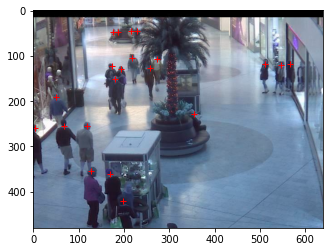

In [11]:

img=plt.imshow(images[22])
img=plt.plot(images_gt[22][:,0],images_gt[22][:,1],'r+')

## Code to generate density map

In [12]:
def generate_density(X,Y):
    point=np.array([X,Y]).T
    leafsize=2048
    tree=spatial.KDTree(point.copy(),leafsize=leafsize)
    distances,locations=tree.query(point,k=4)
    density=np.zeros([480,640],dtype=np.float32)
    for i,pt in enumerate(point):
        pt2d=np.zeros([480,640],dtype=np.float32)
        pt=np.round(pt).astype('int')
        pt2d[pt[1],pt[0]]=1000
        sigma=min(max(1,int(np.sum(distances[i][1:3])*0.1)),8)
        density+=ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    return density

In [13]:
images_density=np.zeros([200,480,640],dtype=np.float32)
for i in tqdm(range(200)):
    images_density[i]=generate_density(images_gt[i][:,0],images_gt[i][:,1])

100%|██████████| 200/200 [01:52<00:00,  1.77it/s]


## Export the generated density map

In [14]:
np.save('/content/drive/My Drive/images_density.npy',images_density)

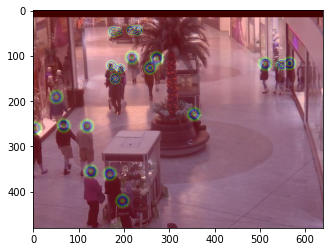

In [16]:

plt.imshow(images[22])
plt.imshow(images_density[22],cmap='prism',interpolation='bicubic',alpha=0.25)